Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9320 - loss: 0.2888 - val_accuracy: 0.9638 - val_loss: 0.1458
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9670 - loss: 0.1254 - val_accuracy: 0.9700 - val_loss: 0.1082
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9694 - loss: 0.0987 - val_accuracy: 0.9737 - val_loss: 0.0849
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9681 - loss: 0.0898 - val_accuracy: 0.9731 - val_loss: 0.0782
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9706 - loss: 0.0816 - val_accuracy: 0.9762 - val_loss: 0.0685
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9724 - loss: 0.0746 - val_accuracy: 0.9756 - val_loss: 0.0660
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9742 - loss: 0.0675 - val_accuracy: 0.9737 - val_loss: 0.0773
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9772 - loss: 0.0657 - val_accuracy: 0.9762 - val_

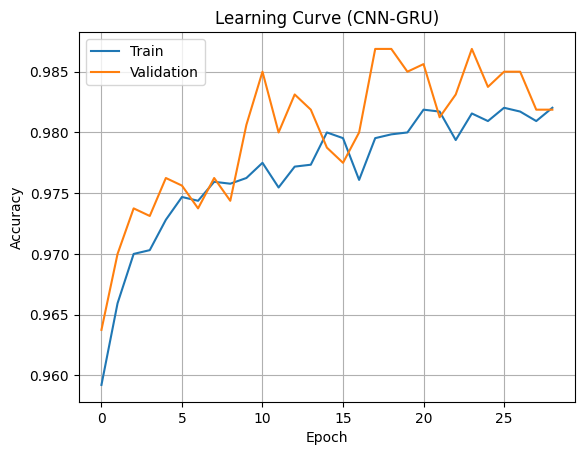

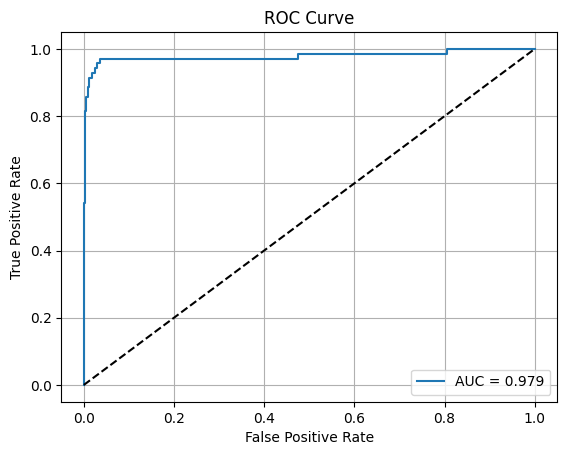

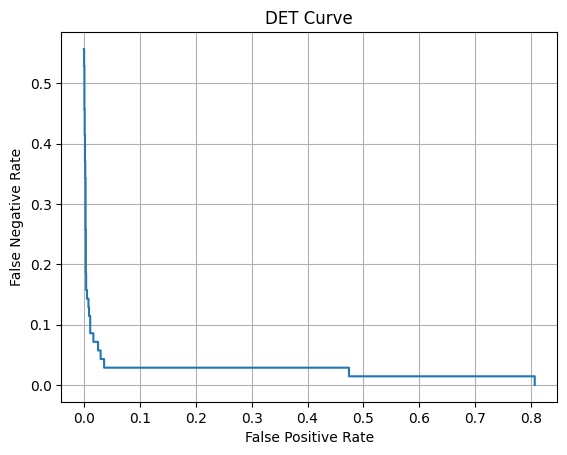

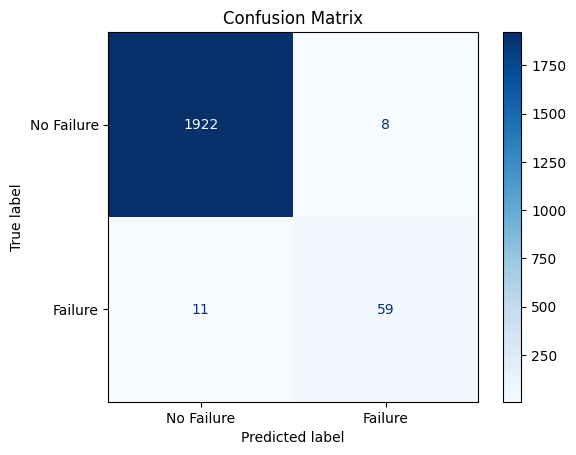

In [1]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, det_curve, ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dropout, Dense

# STEP 2: Load and Prepare Data
df = pd.read_csv("file1.csv")
df["Failure"] = (df["Diagnostic"] != "No failure").astype(int)
df.drop(columns=["UDI", "Date", "Product ID", "Diagnostic"], inplace=True)

X = df.drop(columns=["Failure"])
y = df["Failure"]

# STEP 3: Preprocessing
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# STEP 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# Reshape for CNN-GRU: (samples, time_steps, 1)
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# STEP 5: Build Hybrid Model
def build_cnn_gru(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        GRU(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_cnn_gru(X_train_seq.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# STEP 6: Train
history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

from sklearn.metrics import confusion_matrix, log_loss, matthews_corrcoef, cohen_kappa_score

# STEP 7: Evaluate
y_proba = model.predict(X_test_seq).ravel()
y_pred = (y_proba >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
misclassification_error = (fp + fn) / (tp + tn + fp + fn)
logloss = log_loss(y_test, y_proba)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# Print all metrics
print("\n--- Evaluation Metrics ---")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall (Sensitivity): {rec:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Misclassification Error: {misclassification_error:.4f}")


# STEP 8: Plots

# Learning Curve
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Learning Curve (CNN-GRU)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# DET Curve
fpr, fnr, _ = det_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, fnr, label="DET Curve")
plt.title("DET Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No Failure", "Failure"], cmap="Blues"
)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

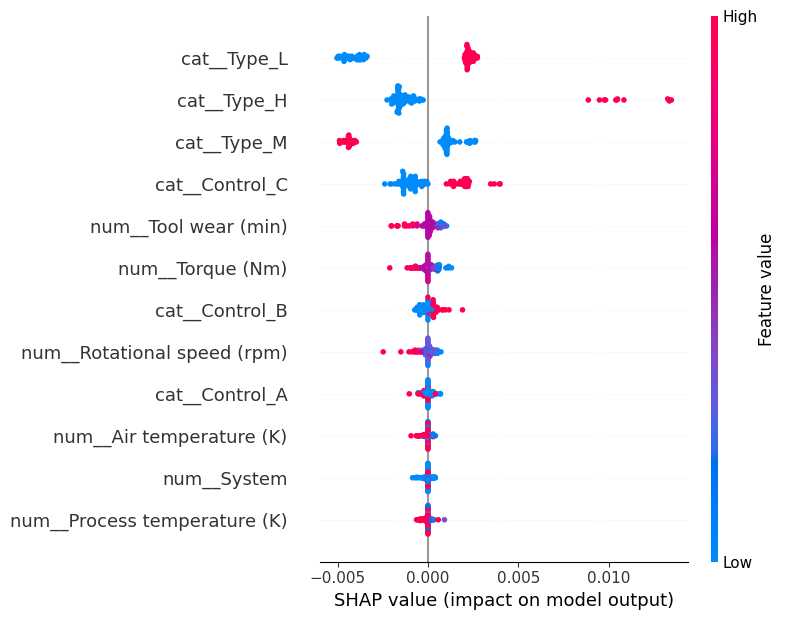

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dropout, Dense

def build_cnn_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

model = build_cnn_gru(X_train_seq.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

import shap
import numpy as np

# Define a prediction function for SHAP (must return 1D probs)
def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))
    return model.predict(x_reshaped, verbose=0).ravel()

X_sample_tabular = X.iloc[:100]
X_background_tabular = X.iloc[100:150]

# Preprocess
X_sample_processed = preprocessor.transform(X_sample_tabular)
X_background_processed = preprocessor.transform(X_background_tabular)

# Run KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_background_processed)
shap_values = explainer.shap_values(X_sample_processed, nsamples=100)

# Plot
feature_names = preprocessor.get_feature_names_out()
feature_names = [str(f) for f in feature_names]
shap.summary_plot(shap_values, X_sample_processed, feature_names=feature_names)


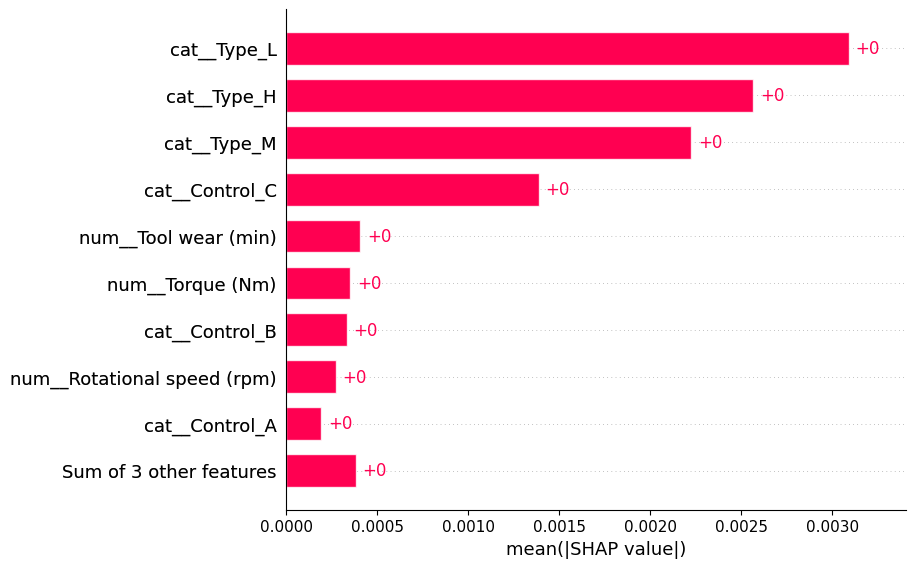

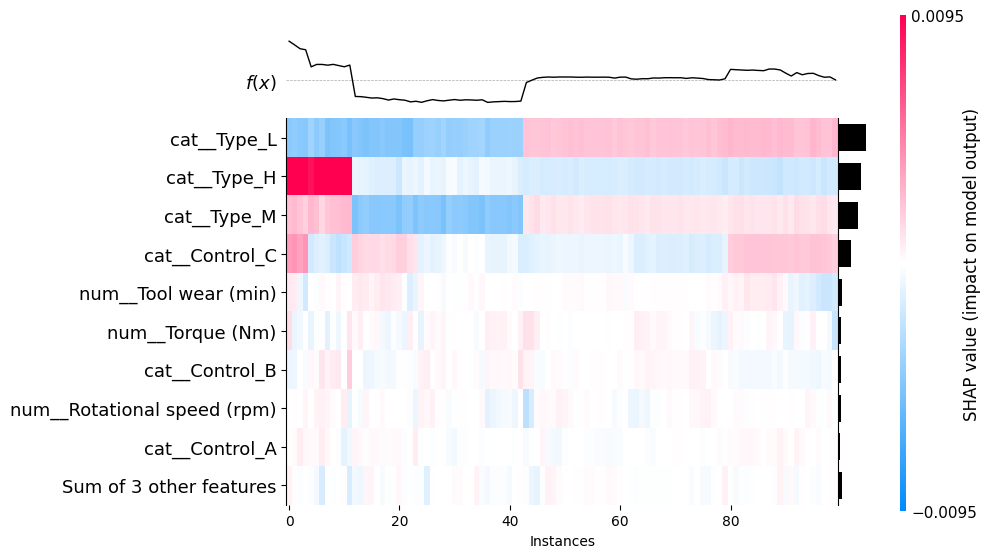

In [3]:
# Ensure base_values is the correct shape (1D array of length = number of samples)
base_values = np.repeat(explainer.expected_value, X_sample_processed.shape[0])

# Create Explanation object
explanation = shap.Explanation(
    values=shap_values,
    base_values=base_values,
    data=X_sample_processed,
    feature_names=feature_names
)

# Bar plot
shap.plots.bar(explanation)

# SHAP heatmap (matrix of SHAP values across samples)
shap.plots.heatmap(explanation)



shap.initjs()

sample_idx = 0
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[sample_idx],
    features=X_sample_processed[sample_idx],
    feature_names=feature_names
)



In [4]:
# 5 Model Variants for Hybrid CNN-GRU Architecture

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dropout, Dense, Add, Bidirectional, MaxPooling1D, BatchNormalization

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, log_loss, matthews_corrcoef, cohen_kappa_score
)

import matplotlib.pyplot as plt
import pandas as pd

# Variant 1: Baseline CNN + GRU
def build_cnn_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="CNN-GRU")

# Variant 2: CNN + Bidirectional GRU
def build_cnn_bi_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(32))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="CNN-BiGRU")

# Variant 3: Deeper CNN + GRU
def build_deep_cnn_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Deep-CNN-GRU")

# Variant 4: CNN + GRU + Residual Connection
def build_cnn_gru_residual(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x_skip = x
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Add()([x, x_skip])
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="CNN-GRU-Residual")

# Variant 5: CNN + GRU + Dense Bottleneck
def build_cnn_gru_bottleneck(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="CNN-GRU-Bottleneck")



In [5]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Training and evaluation function
def train_and_evaluate_model(build_fn, model_name, X_train_seq, y_train, X_test_seq, y_test):
    model = build_fn(X_train_seq.shape[1:])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_seq, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    y_proba = model.predict(X_test_seq).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    results = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "AUC": roc_auc_score(y_test, y_proba),
        "Log Loss": log_loss(y_test, y_proba),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "Kappa": cohen_kappa_score(y_test, y_pred),
        "Misclassification Error": (fp + fn) / (tp + tn + fp + fn)
    }
    return results

# List of model variants
model_variants = [
    ("Baseline CNN-GRU", build_cnn_gru),
    ("Bidirectional GRU", build_cnn_bi_gru),
    ("Deeper CNN + GRU", build_deep_cnn_gru),
    ("Residual CNN-GRU", build_cnn_gru_residual),
    ("CNN-GRU Bottleneck", build_cnn_gru_bottleneck),
]

# Train and evaluate all models
all_results = []
for name, fn in model_variants:
    print(f"Training: {name}")
    result = train_and_evaluate_model(fn, name, X_train_seq, y_train, X_test_seq, y_test)
    all_results.append(result)

# View results
results_df = pd.DataFrame(all_results)
results_df


Training: Baseline CNN-GRU
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training: Bidirectional GRU
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Training: Deeper CNN + GRU
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Training: Residual CNN-GRU
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training: CNN-GRU Bottleneck
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Model,Accuracy,F1 Score,Precision,Recall,Specificity,AUC,Log Loss,MCC,Kappa,Misclassification Error
0,Baseline CNN-GRU,0.9875,0.803150,0.894737,0.728571,0.996891,0.977557,0.036090,0.801252,0.796764,0.0125
1,Bidirectional GRU,0.9885,0.836879,0.830986,0.842857,0.993782,0.981066,0.038604,0.830942,0.830920,0.0115
2,Deeper CNN + GRU,0.9925,0.887218,0.936508,0.842857,0.997927,0.976751,0.031722,0.884662,0.883350,0.0075
3,Residual CNN-GRU,0.9925,0.890511,0.910448,0.871429,0.996891,0.978253,0.032692,0.886858,0.886630,0.0075
4,CNN-GRU Bottleneck,0.9895,0.846715,0.865672,0.828571,0.995337,0.972724,0.037420,0.841498,0.841282,0.0105


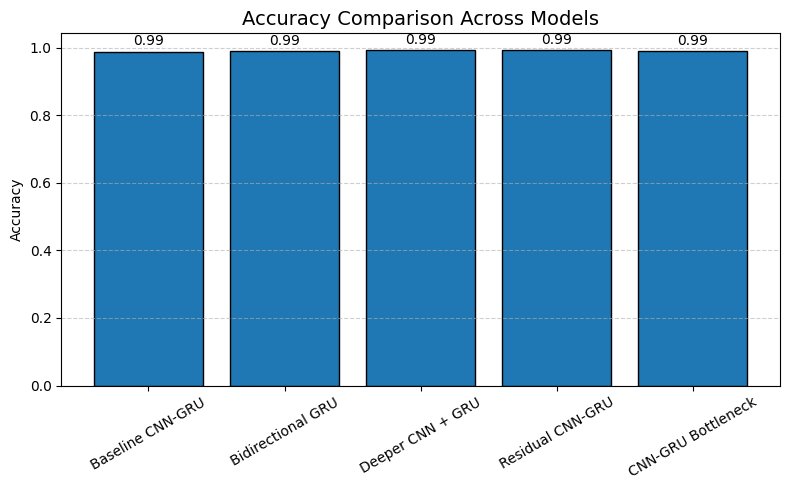

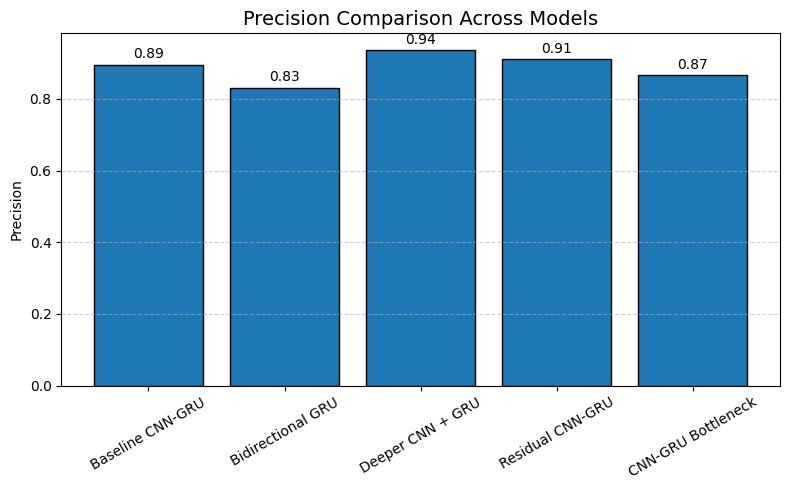

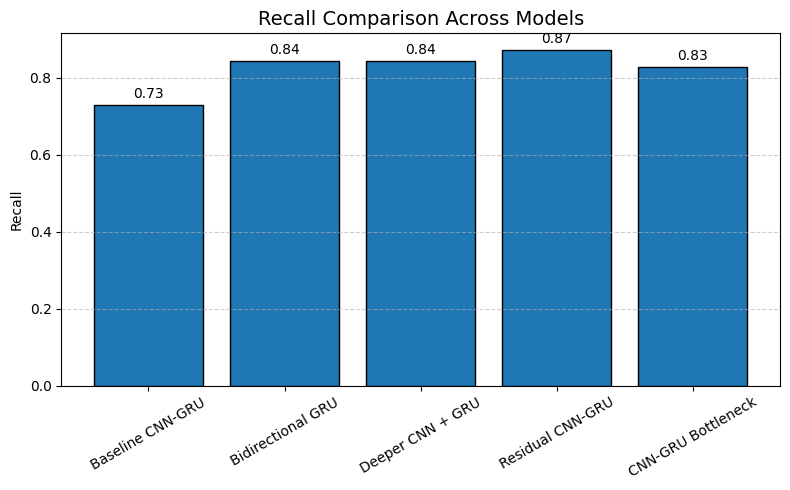

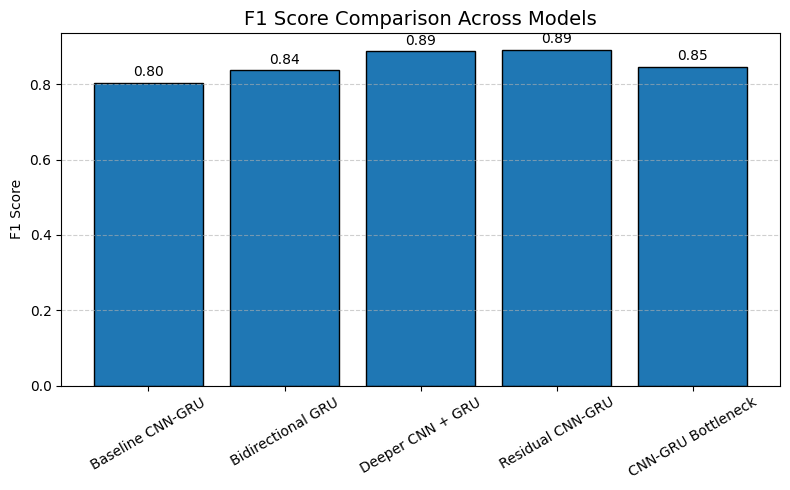

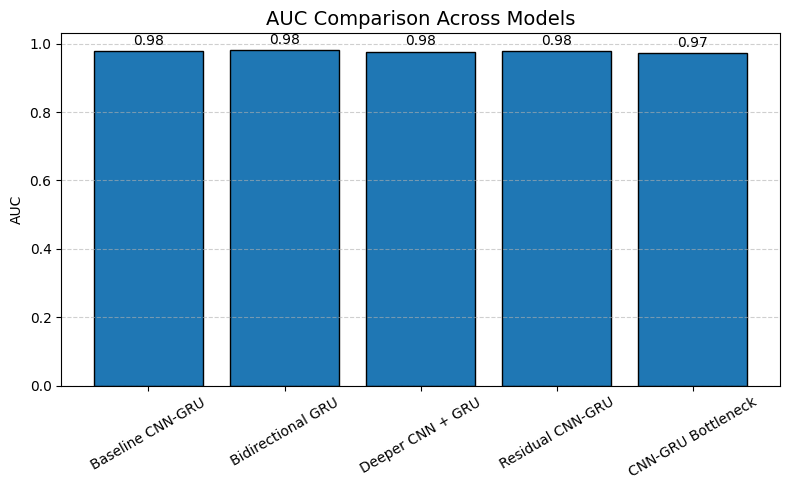

In [6]:
import matplotlib.pyplot as plt

# Plotting function for each metric
def plot_metric_comparison(df, metric):
    plt.figure(figsize=(8, 5))
    bars = plt.bar(df["Model"], df[metric], edgecolor='black')
    plt.title(f"{metric} Comparison Across Models", fontsize=14)
    plt.ylabel(metric)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Annotate bars with values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Plot all main metrics
for metric in ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]:
    plot_metric_comparison(results_df, metric)
